# First Attemp to create a fault visualization in 3D

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import re

## Creating the map

In [2]:
i_coords = [-33.47, -70.655]
site_map = folium.Map(location=i_coords, zoom_start=10, tiles='Stamen Terrain')

Mouse positioning

In [3]:
from folium.plugins import MousePosition
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

## Importing DEM

(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x27570b4cfd0>)

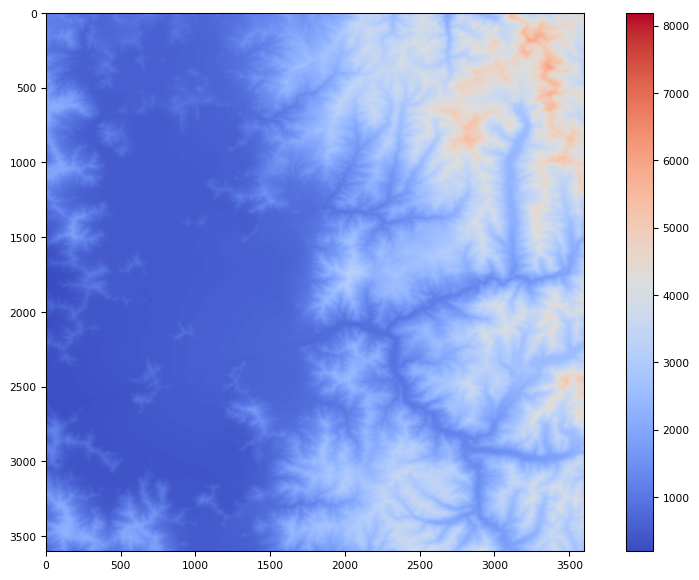

In [4]:
import tifffile as tiff
import matplotlib.pyplot as plt

filename = 'DEM_Stgo.tif'
tfile = tiff.imread(filename)
tiff.imshow(tfile) # display the map

## Extracting Lat, Long and Elev from DEM

In [5]:
from geotiff import GeoTiff
tiff_file = 'DEM_Stgo.tif'
DEM = GeoTiff(tiff_file)
zar_array = GeoTiff.read(DEM)
elev = np.array(zar_array)
lon_array, lat_array = DEM.get_coord_arrays()

In [50]:
# For DEM.txt
with open ('DEM_Stgo.tif.txt','r') as file:
    data = file.read()
    long = re.findall('(?<=[\n])([-]*[\d]{2}[.][\d]+)',data)
    lat = re.findall('(?<=\,)([-]*[\d]{2}[.][\d]+)',data)
    z = re.findall('(?<=\,)([\d]{1,5})',data)
print('Ready!')

Ready!


## Creating a Dataframe

In [6]:
if len(long)==len(lat) & len(z)==len(lat):
    print ('Data OK!')
    print ('Creating dataframe')
    df = pd.DataFrame({'Longitud': long,'Latitud': lat, 'Elevation': z})
    df = df.astype('float')
    print ('Dataframe Created!')
else:
    print('Check Data')

NameError: name 'long' is not defined

## Ploting Topography

### Example Surface Plot

%matplotlib widget \
import matplotlib.pyplot as plt\
from mpl_toolkits.mplot3d import Axes3D\
import numpy as np\


X = np.linspace(-5,5,50)\
Y = np.linspace(-5,5,50)\
X, Y = np.meshgrid(X,Y)


fig = plt.figure()\
ax = fig.add_subplot(projection='3d')\
ax.plot_surface(X, Y, Z, cmap="plasma")\
plt.show()

### Extract and Drop some data to work 

*N work well untill 10^5*

In [28]:
def xyz(n):
    x = []; y = []; z = []
    index = np.linspace(0, len(df)-1, n, endpoint=True, dtype='int')
    for i in index:
        x.append(df['Longitud'][i])
        y.append(df['Latitud'][i])
        z.append(df['Elevation'][i])
    return x,y,z

In [45]:
lat,long,z=xyz(10**4)

### Scatter PLot

In [46]:
def scatt_plot(x,y,z):
    %matplotlib widget
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z,c=z)
    plt.show()

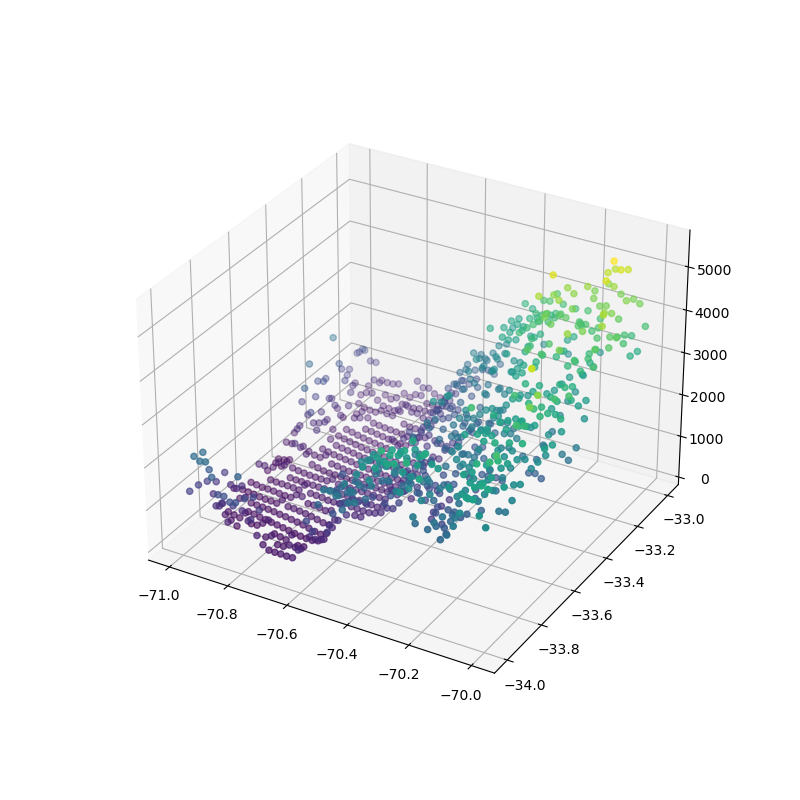

In [47]:
scatt_plot(lat,long,z)

### Surface Plott

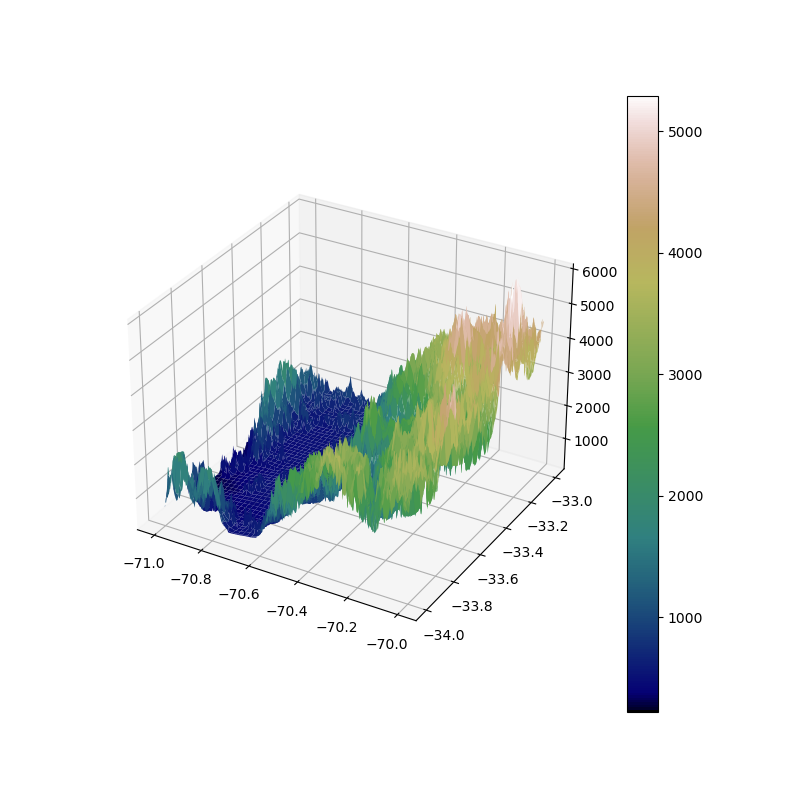

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
fig_=ax.plot_surface(lon_array, lat_array, elev, cmap='gist_earth')
plt.colorbar(fig_)
plt.show()

In [71]:
def tranform_degree_to_meters(array): #for two dimensions
    m = 111120*(array-np.min(array))
    return m

In [72]:
lon_m = tranform_degree_to_meters(lon_array)
lat_m = tranform_degree_to_meters(lat_array)

In [77]:
lon_m.shape

(3601, 3601)

In [14]:
with open('FSR.kml','r') as file:
    data = file.read()

In [58]:
from bs4 import BeautifulSoup
soup = BeautifulSoup (data)

C:\Users\vicen\anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [65]:
coords = []
for t in soup.find_all('coordinates'):
        coords.append(t.get_text("|", strip=True))